# Implementación en numpy

In [15]:
import os
import numpy as np
import pickle
# Perceptron con python: https://pyimagesearch.com/2021/05/06/implementing-the-perceptron-neural-network-with-python/#pyis-cta-modal
# Perceptron con PyTorch: https://www.geeksforgeeks.org/what-is-perceptron-the-simplest-artificial-neural-network/
# Perceptrones multicapa con PyTorch: https://github.com/rasbt/machine-learning-book/blob/main/ch11/ch11.ipynb
# Implementación Forward Propagation: https://www.geeksforgeeks.org/what-is-forward-propagation-in-neural-networks/
# Implementación Back Propagation: https://www.geeksforgeeks.org/backpropagation-in-neural-network/

In [16]:
# https://www.kaggle.com/code/annisin/classification-task
# Imagenes blanco y negro
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Split dataset into training and testing sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixel values to range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [17]:
# Imagenes a color RGB
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10(data_dir='cifar-10-batches-py'):
    # Cargar datos de entrenamiento
    data = []
    labels = []
    for i in range(1, 6):
        batch = unpickle(os.path.join(data_dir, f'data_batch_{i}'))
        data.append(batch[b'data'])
        labels.append(batch[b'labels'])

    data = np.concatenate(data)
    labels = np.concatenate(labels)

    data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
    labels = np.eye(10)[labels]  # One-hot encoding

    # Cargar datos de prueba
    test_batch = unpickle(os.path.join(data_dir, 'test_batch'))
    test_data = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
    test_labels = np.eye(10)[test_batch[b'labels']]

    return data, labels, test_data, test_labels

def load_cifar100(data_dir='cifar-100-python'):
    data = unpickle(os.path.join(data_dir, 'train'))
    x_train = data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
    y_train = np.eye(100)[data[b'fine_labels']]

    data = unpickle(os.path.join(data_dir, 'test'))
    x_test = data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
    y_test = np.eye(100)[data[b'fine_labels']]

    return x_train, y_train, x_test, y_test

¡Perfecto! Aquí tienes una guía paso a paso para implementar una red neuronal multicapa (MLP) para clasificación de imágenes, siguiendo la consigna y los recursos que mencionaste:

1. **Preparar los datos**
   - Descarga y carga los datasets (MNIST, CIFAR-10, CIFAR-100).
   - Preprocesa: normaliza los valores de píxeles y convierte las etiquetas a formato numérico o one-hot.

2. **Implementación en numpy (bajo nivel)**
   - Define la arquitectura: decide el número de capas ocultas y neuronas por capa.
   - Inicializa los pesos y sesgos aleatoriamente.
   - Implementa la propagación hacia adelante (forward propagation) usando funciones de activación (sigmoide, ReLU, etc.).
   - Implementa la retropropagación (backpropagation) para actualizar los pesos usando el gradiente descendente.
   - Entrena la red: itera sobre los datos, calcula la pérdida y ajusta los pesos.

3. **Implementación en PyTorch**
   - Usa `torch.nn.Module` para definir la red.
   - Usa `torch.utils.data.DataLoader` para manejar los datasets.
   - Define la función de pérdida y el optimizador.
   - Entrena la red y evalúa el desempeño.

4. **Experimentación**
   - Prueba diferentes arquitecturas: número de capas, neuronas, funciones de activación, tasas de aprendizaje, momentum, inicialización de pesos.
   - Compara los resultados y documenta cuál configuración funciona mejor.

5. **Comparación con el paper NoProp**
   - Lee el artículo y compara tus resultados con los reportados.
   - Si encuentras implementaciones públicas de NoProp, prueba y compara su desempeño.

6. **Informe**
   - Documenta el proceso, los experimentos y las conclusiones.
   - Incluye gráficos de precisión, pérdida, etc.

¿Te gustaría que te ayude a armar la estructura inicial del notebook o prefieres avanzar por tu cuenta y consultarme dudas puntuales?

### Implementación

In [18]:
class Perceptron:
    """
    Implementación de un perceptrón simple.
    Cada perceptrón tiene sus propios pesos y bias, y utiliza la función de activación sigmoide.
    """
    def __init__(self, input_size, learning_rate=0.1):
        # Inicialización de pesos y bias con valores pequeños aleatorios
        # Esto ayuda a romper la simetría y permite que cada neurona aprenda cosas distintas
        # self.weights = np.random.randn(input_size)
        # self.bias = np.random.randn()
        limit = np.sqrt(6 / (input_size + 1))
        self.weights = np.random.uniform(-limit, limit, input_size)
        self.bias = 0.0
        self.learning_rate = learning_rate

    def activation(self, x):
        # Función de activación sigmoide
        # Convierte la suma ponderada en un valor entre 0 y 1
        return 1 / (1 + np.exp(-x))

    def activation_derivative(self, x):
        # https://interactivechaos.com/es/manual/tutorial-de-deep-learning/derivada-de-la-funcion-sigmoide
        # Derivada de la sigmoide
        # x es el valor de la activación sigmoide. Es decir, se ejecutará esto en realidad => sigmoid(x) * (1 - sigmoid(x))
        return x * (1 - x)

    def forward(self, x):
        # Propagación hacia adelante de una sola muestra
        # Calcula la suma ponderada y aplica la función de activación
        z = np.dot(x, self.weights) + self.bias
        return self.activation(z)

    def update(self, x, delta):
        # Actualiza los pesos y bias usando el gradiente calculado (delta)
        # delta ya incluye la derivada de la sigmoide (por la regla de la cadena)
        # La actualización sigue la dirección del gradiente descendente
        self.weights += self.learning_rate * delta * x
        self.bias += self.learning_rate * delta

In [19]:
class NeuralNetwork:
    """
    Red neuronal multicapa compuesta por capas de perceptrones.
    Permite definir cualquier cantidad de capas y neuronas por capa.
    """
    def __init__(self, layer_sizes, learning_rate=0.1):
        # layer_sizes: lista con el tamaño de cada capa, EJEMPLO: [784, 100, 10]
        self.layers: list[list[Perceptron]] = []
        self.learning_rate = learning_rate
        for i in range(1, len(layer_sizes)):
            capa = [Perceptron(layer_sizes[i-1], learning_rate) for _ in range(layer_sizes[i])]
            # EJEMPLO:
            # - Para la primera capa oculta generaria 100 neuronas que aceptan vectores inputs de 784 dimensiones (input layer).
            # - Para la capa de input no se crea un perceptrón, ya que es la entrada de la red.
            # - La capa de salida generaria 10 neuronas que aceptan vectores inputs de 100 dimensiones (capa oculta).
            self.layers.append(capa)
        
        # Mostrar la estructura de la red
        # print("Estructura de la red:")
        # for i, capa in enumerate(self.layers):
        #     print(f"Capa {i+1}: {len(capa)} neuronas, cada una con {capa[0].weights.shape[0]} pesos")
        # print("\nPesos de la capa intermedia:")
        # for idx, neuron in enumerate(self.layers[0]):
        #     print(f"Neurona {idx}: {neuron.weights}")
        print("\nPesos de la capa de salida:")
        for idx, neuron in enumerate(self.layers[-1]):
            print(f"Neurona {idx}: {neuron.weights}")

    def forward(self, x):
        # Propagación hacia adelante para una muestra
        activations = [x]   # Inicialmente arranca con el input (x, vector de entrada)
        for capa in self.layers:
            salida_capa = np.array([neuron.forward(activations[-1]) for neuron in capa])
            activations.append(salida_capa)
        return activations

    def predict(self, x):
        # Predicción para una muestra
        activations = self.forward(x)
        return activations[-1]

    def train(self, X, Y, epochs=10, X_val=None, Y_val=None):
        """
        Entrenamiento usando backpropagation.
        Ahora guarda el historial de loss y accuracy para graficar.
        Si se pasan X_val, Y_val, también calcula métricas de validación.
        """
        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}  # Diccionario para guardar métricas
        # Entrenamiento usando backpropagation (solo para fines didácticos, no optimizado)
        for epoch in range(epochs):
            total_loss = 0
            correct = 0
            for xi, yi in zip(X, Y):
                # Forward
                activations = self.forward(xi)  # activations es una lista de arrays, donde cada array es la salida de cada capa (función de activación sigmoidea aplicada)
                # Backward
                deltas = [None] * len(self.layers)
                # Capa de salida
                error = yi - activations[-1]    # Resta de vectores
                total_loss += np.sum((error) ** 2) / 2  # Suma de errores cuadráticos (MSE)
                if np.argmax(activations[-1]) == np.argmax(yi):
                    correct += 1
                deltas[-1] = error * np.array([
                    neuron.activation_derivative(activations[-1][j])
                    for j, neuron in enumerate(self.layers[-1])
                ])
                # Capas ocultas
                for l in reversed(range(len(self.layers)-1)):
                    delta_next = deltas[l+1]    # lista de deltas de la capa siguiente (son 10 deltas)
                    pesos_next = np.array([neuron.weights for neuron in self.layers[l+1]])  # En la primera iteracion para MNIST, es un array de arrays de pesos de la capa siguiente -> matriz de 10 filas y 100 columnas
                    # deprecated: deltas[l] = self.layers[l][0].activation_derivative(activations[l+1]) * np.dot(pesos_next.T, delta_next)
                    deltas[l] = np.array([
                        neuron.activation_derivative(activations[l+1][j])
                        for j, neuron in enumerate(self.layers[l])
                    ]) * np.dot(pesos_next.T, delta_next)   # el resultado del producto escalar (np.dot) es un vector de 100 dimensiones (deltas de la capa oculta)

                # Actualización de pesos
                for l, capa in enumerate(self.layers):
                    for j, neuron in enumerate(capa):
                        neuron.update(activations[l], deltas[l][j])
                        # para calcular el delta de cada neurona, se usa la derivada de la activación de esa neurona (activations[l+1][j])
                        # pero para actualizar los pesos, cada neurona necesita todas las salidas de la capa anterior, no solo una (activations[l]) -> entonces, actualiza cada peso de cada feature, sumando al vector de pesos el vector corrección

            acc = correct / len(X)
            history['loss'].append(total_loss / len(X))  # Promedio de loss por muestra
            history['accuracy'].append(acc)              # Accuracy de entrenamiento

            # Validación (si se pasa X_val, Y_val)
            if X_val is not None and Y_val is not None:
                val_loss = 0
                val_correct = 0
                for xi, yi in zip(X_val, Y_val):
                    out = self.predict(xi)
                    val_loss += np.sum((yi - out) ** 2) / 2
                    if np.argmax(out) == np.argmax(yi):
                        val_correct += 1
                history['val_loss'].append(val_loss / len(X_val))
                history['val_accuracy'].append(val_correct / len(X_val))
            if epoch % max(1, epochs//10) == 0:
                # Imprime métricas cada 10% de las épocas
                print(f"Epoch {epoch+1}/{epochs} - Loss: {history['loss'][-1]:.4f} - Acc: {acc:.4f}")
        return history  # Devuelve el historial para graficar


### Prueba de dataset MNIST

In [20]:
# Preparamos un subconjunto pequeño de MNIST para entrenamiento rápido
# Usamos solo las primeras 100 muestras para entrenamiento y 10 para test
# X_train = x_train.reshape((x_train.shape[0], -1))[:1000]
# y_train = y_train[:1000]
# X_test = x_test.reshape((x_test.shape[0], -1))[:100]
# y_test = y_test[:100]

# 1. Seleccionamos un porcentaje del total (por ejemplo, 200 muestras)
n_samples = 10000  # Cambia este valor para usar más o menos datos
X = x_train.reshape((x_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

# 2. Hacemos un split 80/20 sobre ese subconjunto
split = int(0.8 * n_samples)
X_train = X[:split]
y_train = Y[:split]
X_test = X[split:]
y_test = Y[split:]

y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [7]:
# Definimos la arquitectura: 1 capa oculta de 32 neuronas
input_size = X_train.shape[1]  # 784 para MNIST
hidden_size1 = 64
hidden_size2 = 32  # Capa oculta adicional
output_size = 10  # 10 clases

# Creamos la red
mlp = NeuralNetwork([input_size, hidden_size1, output_size], learning_rate=0.01)

# Entrenamos la red (puede tardar unos minutos)
mlp.train(X_train, y_train, epochs=100)


Pesos de la capa de salida:
Neurona 0: [-0.24895096  0.18231164  0.26439038 -0.10454014 -0.12839986 -0.20053704
  0.2244552  -0.08460811  0.00876722  0.08135934 -0.13149591  0.15914951
 -0.0683819  -0.05694793 -0.20582158  0.02330221  0.19146976  0.07806321
 -0.17897867  0.28658037  0.16955787  0.17125755  0.08706117 -0.26492833
 -0.21625729  0.28169113  0.02486031  0.16866392 -0.20334517  0.08997168
  0.01797582  0.10925218 -0.02164579  0.00199398  0.09167938  0.13580718
  0.18720513 -0.18264432  0.00722254 -0.16626638 -0.21773665 -0.11319622
 -0.16101295  0.09796155  0.30203983 -0.13969632 -0.24636571 -0.27831457
 -0.28515012 -0.16290185  0.06750532  0.19109678  0.24801986  0.16283518
  0.05561495 -0.24265247  0.19046332  0.0654951  -0.03362366 -0.2352141
  0.2385619   0.19920572 -0.024162    0.08049944]
Neurona 1: [-0.28118317  0.1842128   0.28460518 -0.15202439 -0.23973676  0.00675756
 -0.22633488  0.04980833 -0.03859114  0.01396732 -0.29299619  0.09550206
 -0.0033398   0.16035213

KeyboardInterrupt: 

In [ ]:
# Evaluamos la red en el subconjunto de test
correct = 0
for xi, yi in zip(X_test, y_test):
    pred = mlp.predict(xi)
    if np.argmax(pred) == np.argmax(yi):
        correct += 1
print(f"Precisión en el subconjunto de test: {correct}/{len(X_test)}")

Precisión en el subconjunto de test: 1855/2000


In [23]:
import matplotlib.pyplot as plt
# 1. Seleccionamos un porcentaje del total (por ejemplo, 10000 muestras)
n_samples = 10000  # Cambia este valor para usar más o menos datos
X = x_train.reshape((x_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

# 2. Hacemos un split 80/20 sobre ese subconjunto
split = int(0.8 * n_samples)
X_train = X[:split]
y_train = Y[:split]
X_val = X[split:]
y_val = Y[split:]

# Definimos la arquitectura: 1 capa oculta de 64 neuronas
input_size = X_train.shape[1]  # 784 para MNIST
hidden_size1 = 64
output_size = 10  # 10 clases

# Creamos la red
mlp = NeuralNetwork([input_size, hidden_size1, output_size], learning_rate=0.01)

# Entrenamos la red y guardamos el historial
history = mlp.train(X_train, y_train, epochs=50, X_val=X_val, Y_val=y_val)  # epochs puede ajustarse


Pesos de la capa de salida:
Neurona 0: [-0.16401604  0.15567599 -0.11319454 -0.26951802 -0.25081176  0.30184885
 -0.03771953  0.01156215 -0.27296362 -0.22956053  0.0501357  -0.28427692
 -0.12471506  0.07558758  0.03796599  0.11384342 -0.14985879  0.24287339
  0.01152417 -0.00760764  0.07830051  0.13297823 -0.05689369  0.11614255
 -0.30314096  0.1777578   0.11927604 -0.06869325 -0.14110632  0.02734894
 -0.04284664 -0.26420878 -0.10174603 -0.30239587  0.26631594  0.13283783
 -0.05866858  0.14054796 -0.14668488  0.02876585 -0.30229597  0.11565026
 -0.05797583  0.07881717 -0.2282057  -0.17488418 -0.18769659 -0.07524423
 -0.03822435 -0.22074759  0.17856357 -0.26741681 -0.03345555  0.10400523
  0.13140356  0.21428683 -0.01722493  0.17592196 -0.17844831 -0.04996013
 -0.2174864  -0.14600714 -0.03578082 -0.10970115]
Neurona 1: [-0.27896888 -0.25989599 -0.07427193 -0.18849805  0.1313567  -0.2354803
  0.26749975 -0.04025628 -0.15213493 -0.00664127 -0.28708317 -0.16200029
  0.27604522 -0.14489774

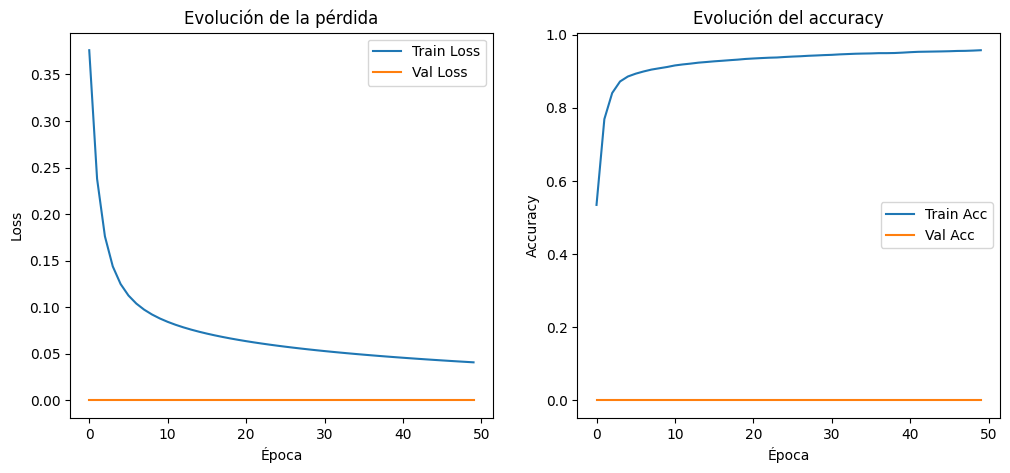

In [26]:
# --- GRAFICAR LOSS Y ACCURACY ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.title('Evolución de la pérdida')

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'], label='Val Acc')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Evolución del accuracy')
plt.show()

### Prueba de dataset CIFAR-10

In [ ]:
# Cargamos los datos
X_train, y_train, X_test, y_test = load_cifar10(f"data/CIFAR-10")

# Aplanamos las imágenes (de 32x32x3 a 3072)
X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)

# 1. Seleccionamos un porcentaje del total (por ejemplo, 200 muestras)
n_samples = 10000  # Cambia este valor para usar más o menos datos
X = X_train.reshape((X_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

X_train = X
y_train = Y

# Definimos la arquitectura: dos capas ocultas
input_size = X_train.shape[1]  # 3072 para CIFAR-10
hidden_size1 = 64
hidden_size2 = 32
output_size = 10  # 10 clases para CIFAR-10

# Creamos la red con dos capas ocultas
mlp = NeuralNetwork([input_size, hidden_size1, hidden_size2, output_size], learning_rate=0.01)

# Entrenamos la red
mlp.train(X_train, y_train, epochs=100)


Pesos de la capa de salida:
Neurona 0: [ 0.1477677  -0.41738491 -0.08644095 -0.11484555 -0.2707198  -0.19403095
  0.35054335  0.22706385 -0.32193181 -0.00324284  0.42421315  0.42534733
  0.32508967 -0.30588869  0.35708655  0.37950966 -0.38865308  0.22606246
 -0.26550155  0.33108974  0.3384983   0.29505282  0.21240173 -0.26799807
 -0.11307818  0.42165967  0.27484448 -0.1775188  -0.06866606 -0.01617937
 -0.3635152   0.13564947]
Neurona 1: [-0.18194418 -0.1253528  -0.40260105  0.32044135 -0.35735428 -0.02679601
  0.00326597  0.2129688   0.03247055 -0.22898612  0.31743093  0.33709559
  0.00900901 -0.39691356 -0.29829105  0.18550242  0.34028104  0.33018925
 -0.11611717  0.01621315 -0.18162352 -0.32001144  0.03703345  0.09502639
  0.38825189 -0.38272885 -0.2738584  -0.34856596 -0.40607581  0.3883104
  0.3052759   0.30937379]
Neurona 2: [-0.32583216 -0.36905487  0.29055989 -0.00968656  0.21323516  0.1680995
  0.18045828 -0.01450863  0.36893808 -0.40191485  0.15677245 -0.39201369
  0.0178203 

AttributeError: 'NeuralNetwork' object has no attribute 'evaluate'

In [ ]:
# Evaluamos la red en el subconjunto de test
correct = 0
for xi, yi in zip(X_test, y_test):
    pred = mlp.predict(xi)
    if np.argmax(pred) == np.argmax(yi):
        correct += 1
print(f"Precisión en el subconjunto de test: {correct}/{len(X_test)}")

Precisión en el subconjunto de test: 4135/10000


### Prueba de dataset CIFAR-100

In [ ]:
# Cargamos los datos
X_train, y_train, X_test, y_test = load_cifar100(f"data/CIFAR-100")

# Aplanamos las imágenes (de 32x32x3 a 3072)
X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)

n_samples = 10000  # Cambia este valor para usar más o menos datos
X = X_train.reshape((X_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

X_train = X
y_train = Y

# Definimos la arquitectura: dos capas ocultas
input_size = X_train.shape[1]  # 3072 para CIFAR-100
hidden_size1 = 64
hidden_size2 = 32
output_size = 100  # 100 clases para CIFAR-100

# Creamos la red con dos capas ocultas
mlp = NeuralNetwork([input_size, hidden_size1, hidden_size2, output_size], learning_rate=0.01)

# Entrenamos la red
mlp.train(X_train, y_train, epochs=100)


Pesos de la capa de salida:
Neurona 0: [ 0.16149942  0.23627933 -0.28908691  0.39345024 -0.08104062 -0.23324945
  0.21863577 -0.28295031  0.1518131  -0.16635039 -0.26036811 -0.12841487
 -0.2764827  -0.39290738 -0.04446165 -0.34524737  0.30438739  0.29481635
  0.15002793  0.42369625  0.40029829 -0.05680715  0.07344367  0.02879389
 -0.35461295 -0.12476387 -0.05514851  0.29654483  0.27802241 -0.13946806
 -0.22407028  0.16049434]
Neurona 1: [-0.0872708   0.03684712 -0.30554699 -0.39983352 -0.3891758  -0.1882959
 -0.28902896  0.11698839 -0.25335911  0.33672191  0.13416491  0.34177103
  0.40010698  0.11538929 -0.4118487  -0.08633582  0.38075734 -0.34908716
  0.38490133  0.25667329 -0.08898306 -0.27569107 -0.11044568  0.27236445
  0.16801309  0.20289735 -0.39247359 -0.09478912 -0.13081586 -0.10912207
  0.11434673  0.16672428]
Neurona 2: [-0.38758939  0.19497116 -0.15027481 -0.00564935 -0.3759918   0.23775133
  0.21311233 -0.10136635 -0.21455555  0.02503643 -0.04981712  0.21271956
 -0.0855241

KeyboardInterrupt: 

In [ ]:
# Evaluamos la red en el subconjunto de test
correct = 0
for xi, yi in zip(X_test, y_test):
    pred = mlp.predict(xi)
    if np.argmax(pred) == np.argmax(yi):
        correct += 1
print(f"Precisión en el subconjunto de test: {correct}/{len(X_test)}")

# Implementación con Pytorch

### Implementación

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [9]:
# https://www.kaggle.com/code/annisin/classification-task
# Imagenes blanco y negro
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Split dataset into training and testing sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixel values to range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [10]:
class NeuralNetworkPyTorch:
    def __init__(self, layer_sizes, learning_rate=0.01, device=None):
        """
        layer_sizes: lista con tamaño de capas, e.g., [3072, 64, 32, 100]
        """
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.build_model(layer_sizes).to(self.device)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate)
    
    def build_model(self, sizes):
        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            layers.append(nn.Sigmoid())  # Usamos Sigmoid para imitar tu perceptrón
        # Capa final (sin Sigmoid, CrossEntropy incluye softmax internamente)
        layers.append(nn.Linear(sizes[-2], sizes[-1]))
        return nn.Sequential(*layers)

    def train(self, X, Y, epochs=10, batch_size=64):
        """
        X: tensor (n_samples x input_dim)
        Y: tensor de etiquetas (n_samples,) tipo long (no one-hot)
        """
        dataset = torch.utils.data.TensorDataset(X, Y)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            total_loss = 0
            for batch_X, batch_Y in loader:
                batch_X = batch_X.to(self.device)
                batch_Y = batch_Y.to(self.device)

                outputs = self.model(batch_X)
                loss = self.loss_fn(outputs, batch_Y)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            
            if epoch % max(1, epochs // 10) == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(loader):.4f}")

    def predict(self, X):
        """
        X: tensor (n_samples x input_dim)
        return: tensor con índices de clases predichas
        """
        self.model.eval()
        with torch.no_grad():
            X = X.to(self.device)
            outputs = self.model(X)
            predictions = torch.argmax(outputs, dim=1)
        return predictions
    



### Prueba con dataset MNIST

In [11]:
# 1. Seleccionamos un porcentaje del total (por ejemplo, 200 muestras)
n_samples = 10000  # Cambia este valor para usar más o menos datos
X = x_train.reshape((x_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

# 2. Hacemos un split 80/20 sobre ese subconjunto
split = int(0.8 * n_samples)
X_train = X[:split]
y_train = Y[:split]
X_test = X[split:]
y_test = Y[split:]

In [12]:
# Definimos la arquitectura: 1 capa oculta de 32 neuronas
input_size = X_train.shape[1]  # 784 para MNIST
hidden_size1 = 64
hidden_size2 = 32  # Capa oculta adicional
output_size = 10  # 10 clases

# Creamos la red
mlp = NeuralNetworkPyTorch([input_size, hidden_size1, output_size], learning_rate=0.01)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

# Entrenamos la red (puede tardar unos minutos)
mlp.train(X_train_tensor, y_train_tensor, epochs=100)

Epoch 1/100 - Loss: 2.3000
Epoch 11/100 - Loss: 1.7372
Epoch 21/100 - Loss: 1.0731
Epoch 31/100 - Loss: 0.7597
Epoch 41/100 - Loss: 0.6038
Epoch 51/100 - Loss: 0.5137
Epoch 61/100 - Loss: 0.4557
Epoch 71/100 - Loss: 0.4154
Epoch 81/100 - Loss: 0.3855
Epoch 91/100 - Loss: 0.3625


In [13]:
preds = mlp.predict(X_test_tensor)
accuracy = (preds == y_test_tensor).float().mean().item()
print(f"Precisión en el subconjunto de test: {accuracy * 100:.2f}%")

Precisión en el subconjunto de test: 88.75%
